## 1. Carga de datos y creación del tablón analítico

### Librerias

En primer lugar, vamos a cargar todas las librerías necesarias para la realización de este trabajo:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.feature_selection import chi2 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

### Lectura de datos

A continuación, leemos las tablas que contienen la información necesaria para el estudio.

In [2]:
clientes_d = pd.read_csv('clientes_diciembre.csv', sep='|')
consumos_d = pd.read_csv('consumos_diciembre.csv', sep ='|')
financiacion_d = pd.read_csv('financiacion_diciembre.csv', sep='|')
productos_d = pd.read_csv('productos_diciembre.csv', sep='|')

In [3]:
clientes_e= pd.read_csv('clientes_enero.csv', sep='|')
consumos_e = pd.read_csv('consumos_enero.csv', sep ='|')
financiacion_e = pd.read_csv('financiacion_enero.csv', sep='|')
productos_e = pd.read_csv('productos_enero.csv', sep='|')

### Union de tablas

Vamos a comprobar las dimensiones de las tablas para unirlas.

In [4]:
print('Tabla clientes_d:', clientes_d.shape)
print('Tabla consumos_d:', consumos_d.shape)
print('Tabla financiacion_d:', financiacion_d.shape)
print('Tabla productos_d:', productos_d.shape)

Tabla clientes_d: (95467, 8)
Tabla consumos_d: (95467, 6)
Tabla financiacion_d: (24198, 4)
Tabla productos_d: (95467, 4)


In [5]:
print('Tabla clientes_e:', clientes_e.shape)
print('Tabla consumos_e:', consumos_e.shape)
print('Tabla financiacion_e:', financiacion_e.shape)
print('Tabla productos_e:', productos_e.shape)

Tabla clientes_e: (92711, 8)
Tabla consumos_e: (92711, 6)
Tabla financiacion_e: (25332, 4)
Tabla productos_e: (92711, 4)


Todas las tablas tienen el mismo número de filas excepto financiación, que la uniremos al resto a través de un left join. Esto se debe porque esta tabla solo incluye a los clientes que tienen una financiación o un descuento y no recoge a los clientes que no tienen. Unimos todas las tablas a través del id ya que es un valor unico.

In [6]:
sum(clientes_d['id']==consumos_d['id'])

95467

In [7]:
sum(clientes_e['id']==consumos_e['id'])

92711

**Unimos las tablas de diciembre:** 

In [8]:
df1 = pd.merge(clientes_d, consumos_d, on='id') 
df2 = pd.merge(df1, financiacion_d, on='id', how='left')
df_dic = pd.merge(df2, productos_d, on='id')
df_dic.shape

(95467, 19)

In [9]:
df_dic.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,NaN,NaN,NaN,FIBRA,50MB,tv-futbol
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,NaN,NaN,SI,FIBRA,600MB,tv-futbol
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,129,30,15511,17013,16743,NaN,NaN,SI,ADSL,35MB,tv-futbol
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,51,52,12670,3393,6771,NaN,NaN,NaN,FIBRA,200MB,tv-familiar
4,5,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,NaN,NaN,NaN,ADSL,10MB,tv-futbol


**Unimos las tablas de enero**

In [10]:
df12 = pd.merge(clientes_e, consumos_e, on='id') 
df22 = pd.merge(df12, financiacion_e, on='id', how='left')
df_ene = pd.merge(df22, productos_e, on='id')
df_ene.shape

(92711, 19)

In [11]:
df_ene.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,95,19,6525,7634,18520,NaN,NaN,NaN,FIBRA,50MB,tv-futbol
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,44,36,14471,14541,8016,NaN,NaN,SI,FIBRA,600MB,tv-futbol
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,94,27,1428,5248,7106,NaN,NaN,SI,ADSL,35MB,tv-futbol
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,186,20,20083,7372,5052,NaN,NaN,NaN,FIBRA,200MB,tv-familiar
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN,37,32,19078,5009,8686,NaN,NaN,NaN,FIBRA,200MB,tv-futbol


### Creamos la variable target

Creamos la variable target buscando los clientes que teniamos en diciembre en la tabla de enero, si están, aparecerá TRUE y si no FALSE, por lo que el 0 en la variable que vamos a crear significa que el cliente continua en la compañía y el uno significa que se ha ido de la compañía.

In [12]:
target = clientes_d['id'].isin(clientes_e['id'])
target

0         True
1         True
2         True
3         True
4        False
         ...  
95462     True
95463     True
95464     True
95465     True
95466     True
Name: id, Length: 95467, dtype: bool

In [13]:
churn=target.apply(lambda x: 0 if x==True else 1)
churn.head()

0    0
1    0
2    0
3    0
4    1
Name: id, dtype: int64

In [14]:
df_dic['target']=churn
df_dic.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV,target
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,NaN,NaN,NaN,FIBRA,50MB,tv-futbol,0
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,NaN,NaN,SI,FIBRA,600MB,tv-futbol,0
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,129,30,15511,17013,16743,NaN,NaN,SI,ADSL,35MB,tv-futbol,0
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,51,52,12670,3393,6771,NaN,NaN,NaN,FIBRA,200MB,tv-familiar,0
4,5,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,NaN,NaN,NaN,ADSL,10MB,tv-futbol,1


**Establecemos el id como identificador de filas**

In [15]:
df_dic.set_index(['id'], inplace=True)
df_ene.set_index(['id'], inplace=True)

##  2. Preprocesado y limpieza de datos

**Diciembre**

En primer lugar vamos a imputar los valores nulos de las variables, así como recodificar los valores que no tienen sentido.

In [16]:
df_dic.isnull().sum()

edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            90738
incidencia        91893
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
financiacion      89095
imp_financ        89095
descuentos        76313
conexion              0
vel_conexion          3
TV                    0
target                0
dtype: int64

In [17]:
for i in df_dic.columns:
    print(i)
    print(df_dic[i].value_counts())

edad
37    1721
20    1671
27    1653
26    1644
23    1641
      ... 
63    1262
85    1260
59    1256
48    1244
84    1235
Name: edad, Length: 68, dtype: int64
facturacion
310.914502    1
92.482626     1
193.323023    1
48.654326     1
118.845960    1
             ..
137.408794    1
81.341921     1
251.949354    1
264.974536    1
357.251060    1
Name: facturacion, Length: 95467, dtype: int64
antiguedad
2007-11-16 06:32:00    2
2006-10-08 05:38:00    2
1996-02-02 12:39:00    2
2004-11-20 18:10:00    2
2000-03-27 20:31:00    2
                      ..
2015-12-22 11:59:00    1
2014-09-01 22:26:00    1
2008-04-17 10:38:00    1
1997-10-11 13:45:00    1
1997-08-14 01:03:00    1
Name: antiguedad, Length: 95171, dtype: int64
provincia
Zaragoza                  1991
Navarra                   1986
Málaga                    1973
Valencia                  1972
Asturias                  1972
Murcia                    1967
Orense                    1958
Alicante                  1954
Córdoba     

Observamos valores nulos en la variable num_dt (número de lineas en impago), en incidencia (si el cliente ha tenido alguna incidencia o reclamación), en financiacion (si el cliente tiene financiado algún terminal), imp_financ (dinero mensual que se paga por los terminales financiados), descuentos (si el cliente tiene activo algún descuento) y en vel_conexion. Además en num_lineas y en vel_conexion hay valores mal codificados.

*num_dt*

In [18]:
df_dic.num_dt.value_counts()

4.0    1206
1.0    1179
2.0    1174
3.0    1170
Name: num_dt, dtype: int64

Los valores nulos de esta variable singnifican que el cliente no tiene ninguna linea en impago, por lo que los imputaremos por ceros.

In [19]:
df_dic['num_dt'] = df_dic['num_dt'].fillna(0)
df_dic.num_dt.value_counts()

0.0    90738
4.0     1206
1.0     1179
2.0     1174
3.0     1170
Name: num_dt, dtype: int64

*incidencia*

In [20]:
df_dic.incidencia.value_counts()

SI    3574
Name: incidencia, dtype: int64

Los valores nulos de esta variable son que el cliente no ha tenido ninguna incidencia, los imputaremos por 'NO'

In [21]:
df_dic['incidencia']=df_dic['incidencia'].fillna('NO')
df_dic.incidencia.value_counts()

NO    91893
SI     3574
Name: incidencia, dtype: int64

Y a continuación, transformamos la variable a binaria:

In [22]:
df_dic['incidencia']=df_dic['incidencia'].apply(lambda x: 0 if x=='NO' else 1)

*financiacion*

In [23]:
df_dic.financiacion.value_counts()

SI    6372
Name: financiacion, dtype: int64

Los valores nulos de esta variable son que el cliente no tiene financiación, los imputaremos por 'NO'.

In [24]:
df_dic['financiacion']=df_dic['financiacion'].fillna('NO')
df_dic.financiacion.value_counts()

NO    89095
SI     6372
Name: financiacion, dtype: int64

Y a continuación, transformamos la variable a binaria:

In [25]:
df_dic['financiacion']=df_dic['financiacion'].apply(lambda x: 0 if x=='NO' else 1)

*imp_financ*

In [26]:
df_dic.imp_financ.value_counts()

39.243454    1
27.773702    1
13.844082    1
32.902067    1
37.717607    1
            ..
14.180035    1
11.722279    1
27.875632    1
21.375463    1
28.768734    1
Name: imp_financ, Length: 6372, dtype: int64

Esta variable va ligada a si el cliente tiene financiación o no, por lo que los valores nulos son ceros ya que esos clientes no tienen ninguna financiación.

In [27]:
df_dic['imp_financ']=df_dic['imp_financ'].fillna('0')
df_dic.imp_financ.value_counts()
df_dic['imp_financ']=df_dic['imp_financ'].astype(float)

*descuentos*

In [28]:
df_dic.descuentos.value_counts()

SI    19154
Name: descuentos, dtype: int64

Los valores nulos de esta variable significan que el cliente no tiene descuentos, por lo que los imputaremos por 'NO'.

In [29]:
df_dic['descuentos']=df_dic['descuentos'].fillna('NO')
df_dic.descuentos.value_counts()

NO    76313
SI    19154
Name: descuentos, dtype: int64

Y a continuación, transformamos la variable a binaria:

In [30]:
df_dic['descuentos']=df_dic['descuentos'].apply(lambda x: 0 if x=='NO' else 1)

*vel_conexion*

In [31]:
df_dic.vel_conexion.value_counts()

200MB    9675
600MB    9622
50MB     9474
300MB    9460
100MB    9332
20MB     8113
25MB     8112
10MB     7969
30MB     7948
35MB     7947
15MB     7809
?           1
16598       1
1           1
Name: vel_conexion, dtype: int64

En esta variable encontramos tanto valores nulos como mal codificados (3 valores), por lo que vamos a imputar todos por la moda.

In [32]:
moda = df_dic['vel_conexion'].mode()[0]
moda

'200MB'

In [33]:
df_dic.vel_conexion=df_dic.vel_conexion.replace({'16598': moda, '?': moda, '1':moda})

In [34]:
df_dic['vel_conexion']=df_dic['vel_conexion'].fillna(df_dic['vel_conexion'].mode()[0])

A continuación, vamos a eliminar "MB" para tomar la variable como numérica.

In [35]:
df_dic['vel_conexion']= df_dic['vel_conexion'].str.replace("MB","")
df_dic['vel_conexion'] = pd.to_numeric(df_dic['vel_conexion'],errors='coerce')

In [36]:
df_dic.vel_conexion.value_counts()

200    9681
600    9622
50     9474
300    9460
100    9332
20     8113
25     8112
10     7969
30     7948
35     7947
15     7809
Name: vel_conexion, dtype: int64

Por último, comprobamos que no quedan valores nulos en ninguna variable:

In [37]:
df_dic.isnull().sum()

edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          0
vel_conexion      0
TV                0
target            0
dtype: int64

Una vez que hemos imputado los nulos, vamos a pasar las variables tipo 'object' a tipo numerico para poder introducirlas en el modelo. Además, recodifico la variable num_lineas que tiene valores atipicos.

In [38]:
df_dic.dtypes

edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia          int64
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
financiacion        int64
imp_financ        float64
descuentos          int64
conexion           object
vel_conexion        int64
TV                 object
target              int64
dtype: object

*num_lineas*

Como solo son 3 los valores atípicos, los vamos a recodificar introduciendoles en el grupo de 5 lineas porque más adelante crearemos 3 categorías de esta variable. Si hubiera más casos, podríamos crear una nueva categoría, ya que este número tan elevado de lineas puede deberse a que pertenezcan a una empresa. 

In [39]:
df_dic.num_lineas=df_dic.num_lineas.replace({39: 5, 26: 5, 18:5})
df_dic.num_lineas.value_counts()

3    30013
4    26619
5    22797
2    13186
1     2852
Name: num_lineas, dtype: int64

*TV*

La variable TV la vamos a pasar a numérica.

In [40]:
df_dic.TV.replace(('tv-futbol', 'tv-familiar', 'tv-total'),
                      (1,2,3),inplace=True)

In [41]:
df_dic.TV.value_counts()

1    49634
2    32746
3    13087
Name: TV, dtype: int64

*Conexion*

Igual que hemos hecho con la variable TV, pasamos a numerica la variable conexión.

In [42]:
df_dic.conexion.replace(('ADSL', 'FIBRA'), (1,2), inplace=True)

In [43]:
df_dic.conexion.value_counts()

1    48630
2    46837
Name: conexion, dtype: int64

*Antigüedad*

A través de esta variable de tipo fecha, vamos a obtener la antiguedad de los clientes en número de días.

In [44]:
df_dic['antiguedad']=pd.to_datetime(df_dic['antiguedad'])
fecha = "2020-01-01" #para que recoja los datos del día 31
ahora = datetime.strptime(fecha, '%Y-%m-%d')
df_dic['antig']=ahora - df_dic['antiguedad']
df_dic['antig']=df_dic['antig'].dt.days

In [45]:
df_dic.drop(columns = ['antiguedad'], inplace=True)

*Provincias*

Primero guardamos una lista con las provincias y luego con la funcion de LabelEncoder la transformo a numerica.

In [46]:
provincias = list(df_dic.provincia.unique())

In [47]:
transform = LabelEncoder()
transform.fit_transform(provincias)
prov = transform.transform(df_dic['provincia'])
df_dic['provincia']= prov

Por último compruebo que todas mis variables son numéricas.

In [48]:
df_dic.dtypes

edad                int64
facturacion       float64
provincia           int32
num_lineas          int64
num_dt            float64
incidencia          int64
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
financiacion        int64
imp_financ        float64
descuentos          int64
conexion            int64
vel_conexion        int64
TV                  int64
target              int64
antig               int64
dtype: object

In [49]:
df_dic.head()

,edad,facturacion,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV,target,antig
id,,,,,,,,,,,,,,,,,,,
1,63,216.028109,23,5,0.0,0,110,79,10897,12806,13751,0,0.0,0,2,50,1,0,403
2,84,255.830842,45,3,0.0,0,189,89,18657,6499,10862,0,0.0,1,2,600,1,0,861
3,66,135.768153,0,4,0.0,0,129,30,15511,17013,16743,0,0.0,1,1,35,1,0,6578
4,69,255.658527,26,4,0.0,0,51,52,12670,3393,6771,0,0.0,0,2,200,2,0,1606
5,30,22.302845,40,2,2.0,0,183,3,23756,18436,4485,0,0.0,0,1,10,1,1,8159


## 3. Muestreo de datos

Creamos nuestra variable objetivo 'y' y eliminamos la target del conjunto de datos para hacer las particiones.

In [50]:
y = df_dic['target']
y.value_counts()
df_final1 = df_dic.drop(columns= ['target'])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_final1,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify = y)

## 4. Modelo 

Tras probar con regresión logística, Randon Forest y XGB llegamos a la conclusión de que el modelo que mejor funciona es el XGB mostrado a continuación:

In [52]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))  
    print('sensibilidad')
    print(recall_score(y1, y2))
    confusion=confusion_matrix(y1,y2)
    print('especificidad')
    print(confusion[0,0]/(confusion[0,0]+confusion[0,1]))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)  

C:\Users\nerea\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
matriz de confusión
[[26289   226]
 [  859  1267]]
accuracy
0.9621172445096191
precision
0.8486269256530475
sensibilidad
0.5959548447789276
especificidad
0.991476522722987
f1
0.7001934235976789
AUC
0.7937156837509572


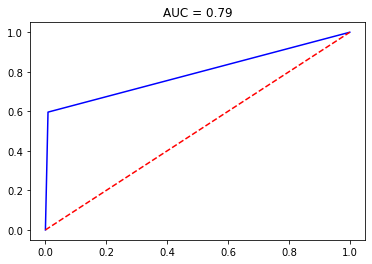

In [53]:
classifier = XGBClassifier(n_estimators = 1000).fit(X_train, y_train)
y_pred     = classifier.predict(X_test)
saca_metricas(y_test, y_pred)

Muestro tambien el segundo mejor modelo porque vamos a necesitarle en futuros pasos.

matriz de confusión
[[26402   113]
 [  982  1144]]
accuracy
0.9617680946894313
precision
0.9101034208432777
sensibilidad
0.5380997177798683
especificidad
0.9957382613614935
f1
0.6763227904227017
AUC
0.7669189895706809


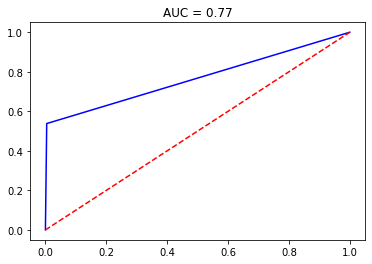

In [54]:
classifier_ = RandomForestClassifier(max_depth = 8).fit(X_train, y_train)
y_pred_    = classifier_.predict(X_test)
saca_metricas(y_test, y_pred_)

El algoritmo que mejor funciona ante este conjunto de datos es XGB. Obtiene un accuracy de 0.9621 y una precision de 0.8486, datos que parecen muy buenos. Respecto a la sensibilidad, como de bien clasifica los unos, obtenemos un resultado de 0.5959, este valor no es muy bueno, pero esto puede deberse a la cantidad de 0 y 1 que tiene nuestra base, están desbalancedados. Por el contrario, la especificidad que obtiene este modelo es muy alta, de un 0.9914, lo que quiere decir que practicamente clasifica bien todos los ceros. Esto se debe una vez más a la cantidad de 0 que tiene el modelo, ya que puede aprender muy bien su comportamiento. F1 arroja un resultado de 0.70, no es mal resultado pero si mejorara la capacidad predictiva de los 1, sería mucho mejor. Por último, la curva Roc arroja un resultado de 0.7937, casi un 80% de los datos se van a predecir de forma correcta, pero habría que mejorar la capacidad predictiva de los unos, ya que de ese porcentaje de ROC los mejores clasificados van a ser los 0.

## 5. Mejora del modelo

**Feature Engineering**

A continuación muestro y grafico las variables de nuestro tablón analitico.

In [55]:
for i in df_dic.columns:
    print(i)
    print(df_dic[i].value_counts())

edad
37    1721
20    1671
27    1653
26    1644
23    1641
      ... 
63    1262
85    1260
59    1256
48    1244
84    1235
Name: edad, Length: 68, dtype: int64
facturacion
310.914502    1
92.482626     1
193.323023    1
48.654326     1
118.845960    1
             ..
137.408794    1
81.341921     1
251.949354    1
264.974536    1
357.251060    1
Name: facturacion, Length: 95467, dtype: int64
provincia
47    1991
31    1986
30    1973
43    1972
3     1972
29    1967
32    1958
1     1954
13    1949
11    1945
6     1939
17    1936
48    1932
44    1931
38    1928
18    1924
36    1922
22    1921
37    1917
8     1915
15    1914
40    1913
46    1913
2     1912
39    1909
28    1907
34    1907
9     1905
12    1902
4     1900
5     1899
20    1899
35    1898
41    1898
49    1893
0     1889
21    1888
16    1881
27    1879
23    1877
26    1871
42    1869
14    1864
33    1860
24    1860
10    1855
7     1853
25    1851
45    1838
19    1831
Name: provincia, dtype: int64
num_lineas
3

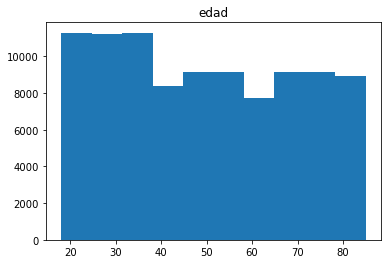

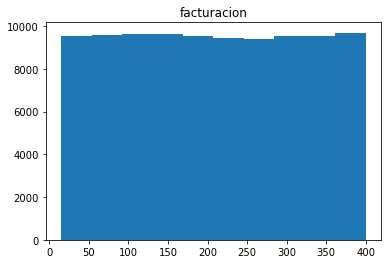

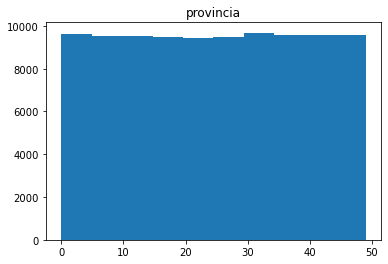

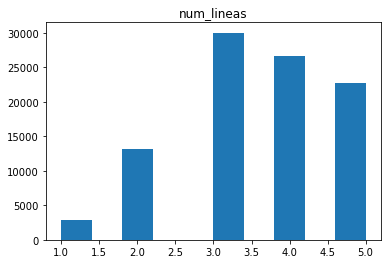

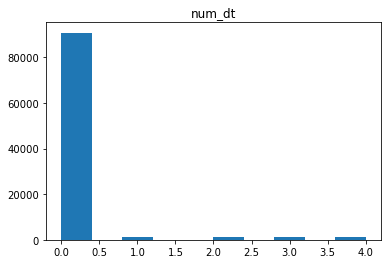

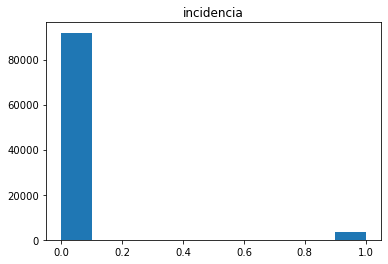

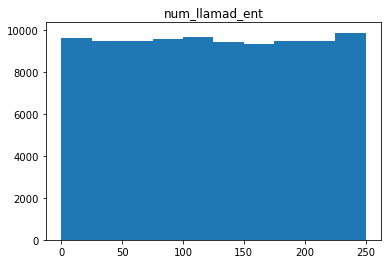

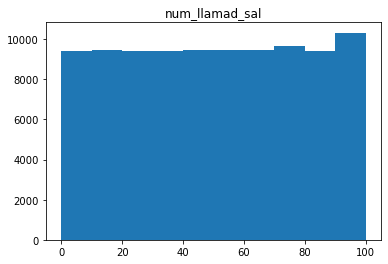

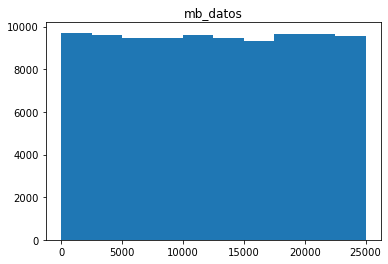

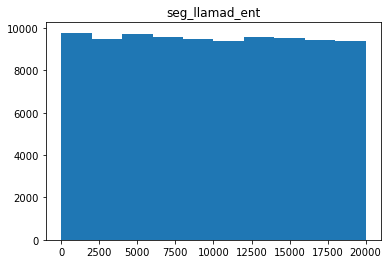

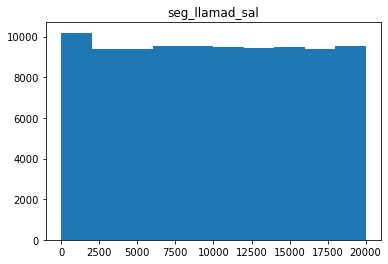

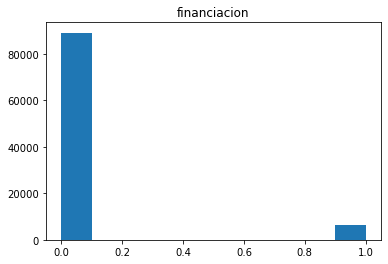

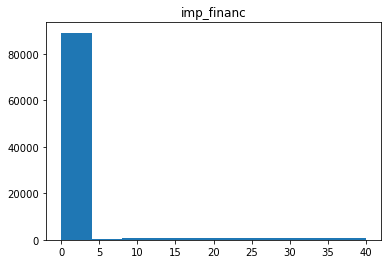

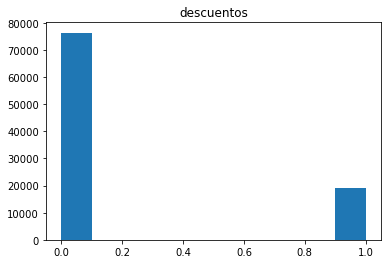

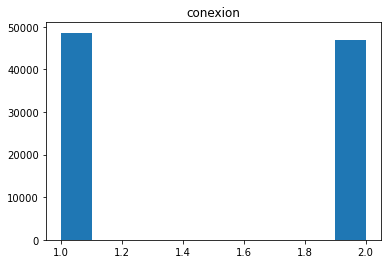

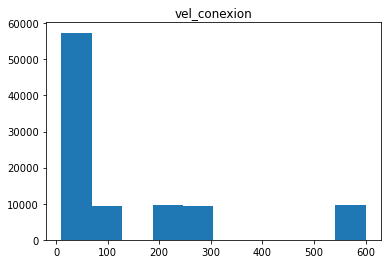

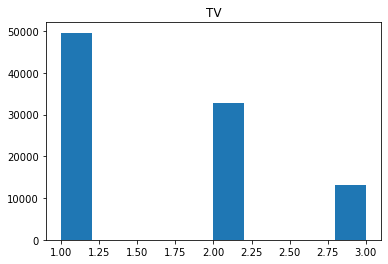

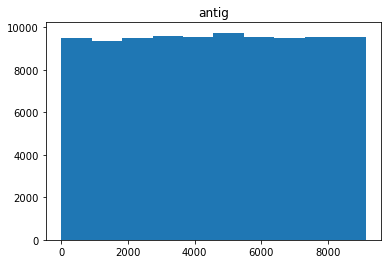

In [56]:
lista_numericas=['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
                'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
                'seg_llamad_ent', 'seg_llamad_sal', 'financiacion', 'imp_financ',
                'descuentos', 'conexion', 'vel_conexion', 'TV', 'antig']
for l in lista_numericas:
    plt.hist(df_dic[l])
    plt.title(l)
    plt.show()

*Edad*: hacemos dos tramos, los jóvenes y los adultos

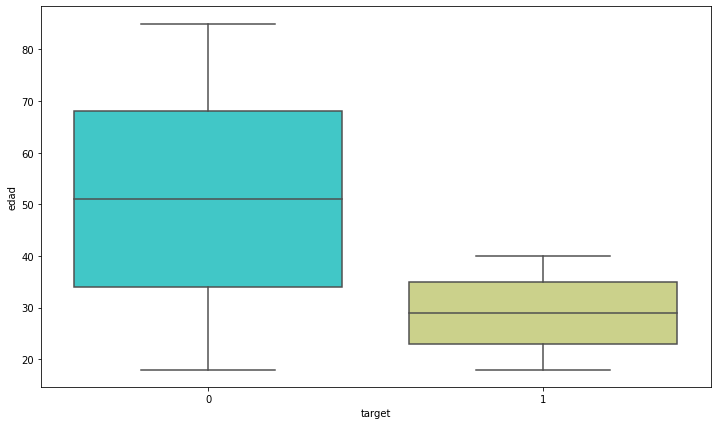

In [57]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='target',y='edad',data=df_dic,palette='rainbow')

Vamos a tramear la variable edaden dos grupos: los menores de 32 y los mayores de 32. Así como crear una variable dummie que sea 1 si la persona es menor de 32 años y 0 si es mayor.

In [58]:
df_dic['age_joven'] = df_dic['edad'].apply(lambda x: 1 if x<=32 else 0)
df_dic['age_adulto'] = df_dic['edad'].apply(lambda x: 1 if x>32 & x<60 else 0)
df_dic['age_new'] = df_dic['edad'].apply(lambda x: 1 if x<=32 else 0)

*vel_conexion*: tramificar la variable vel_conexion en 0-200,200-400 y 400-600

In [59]:
df_dic['vel_conex_new'] = df_dic['vel_conexion'].apply(lambda x: 0 if x<200 else (2 if x>=400 else(1)))

*num_lineas*: creo una nueva variable a partir de la  de numero de lineas dividiendo a los clientes que tienen menos de 2 lineas de los que tienen entre 2 y 4 lineas y los que tienen más de 4. Es por esto, por lo que los 'valores atipicos' los he introducido en 5 lineas.

In [60]:
df_dic['num_lin_new'] = df_dic['num_lineas'].apply(lambda x: 0 if x<2 else (1 if x>=2 and x<4 else(2)))

*num_dt*: creo una variable a partir de num_dt que recoja si el cliente tiene lineas en impago (1) o no (0).

In [61]:
df_dic['lin_impag'] = df_dic['num_dt'].apply(lambda x: 0 if x==0 else (1))

*TV*: creo variables dummies de cada categoría de esta variable.

In [62]:
df_dic['tv_futbol'] = df_dic['TV'].apply(lambda x: 1 if x==1 else 0)
df_dic['tv_familiar'] = df_dic['TV'].apply(lambda x: 1 if x==2 else 0)
df_dic['tv_total'] = df_dic['TV'].apply(lambda x: 1 if x==3 else 0)

*conexion*: creo variables dummies de cada categoría de esta variable

In [63]:
df_dic['ADSL'] = df_dic['conexion'].apply(lambda x: 1 if x==1 else 0)
df_dic['FIBRA'] = df_dic['conexion'].apply(lambda x: 1 if x==2 else 0)

**Modelo con las nuevas variables**

In [64]:
columnas = ['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'financiacion', 'imp_financ',
       'descuentos', 'conexion', 'vel_conexion', 'TV', 'antig',
       'age_joven', 'age_adulto', 'age_new', 'vel_conex_new', 'num_lin_new',
       'lin_impag', 'tv_futbol', 'tv_familiar', 'tv_total', 'ADSL', 'FIBRA']
df_final2 = df_dic[columnas]

Hacemos una nueva partición con nuestras nuevas variables:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_final2,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify = y)

Y aplicamos el modelo ganador de los modelos iniciales:

C:\Users\nerea\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
matriz de confusión
[[26280   235]
 [  851  1275]]
accuracy
0.9620823295276003
precision
0.8443708609271523
sensibilidad
0.5997177798682972
especificidad
0.9911370922119555
f1
0.7013201320132013
AUC
0.7954274360401263


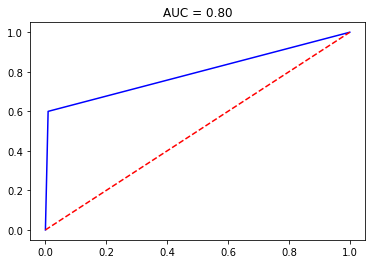

In [66]:
classifier1 = XGBClassifier(n_estimators = 1000).fit(X_train, y_train)
y_pred1     = classifier1.predict(X_test)
saca_metricas(y_test, y_pred1)

**Selección de variables**

A continuación mostramos la lista de las variables según la correlación que tienen con la variable objetivo.

In [67]:
corr = abs(df_dic.corr())
corr[['target']].sort_values(by = 'target',ascending = False).style.background_gradient()

,target
target,1.000000
lin_impag,0.346618
num_dt,0.312795
edad,0.296835
incidencia,0.277408
age_new,0.261045
age_joven,0.261045
TV,0.160122
tv_futbol,0.152493
descuentos,0.141447


Y hacemos una selección de variables que nos muestre cuales son las 15, 10 y 5 mejores variables que introducir al modelo.

In [68]:
S_chi5 = SelectKBest(chi2, k = 16)
X_chi5 = S_chi5.fit_transform(df_dic, df_dic['target'])

variables = list(np.asarray(list(df_dic))[S_chi5.get_support()])
variables.sort()
print(variables)

['TV', 'age_joven', 'age_new', 'antig', 'descuentos', 'edad', 'financiacion', 'imp_financ', 'incidencia', 'lin_impag', 'mb_datos', 'num_dt', 'target', 'tv_familiar', 'tv_futbol', 'tv_total']


In [69]:
S_chi5 = SelectKBest(chi2, k = 11)
X_chi5 = S_chi5.fit_transform(df_dic, df_dic['target'])

variables = list(np.asarray(list(df_dic))[S_chi5.get_support()])
variables.sort()
print(variables)

['age_joven', 'age_new', 'antig', 'descuentos', 'edad', 'imp_financ', 'incidencia', 'lin_impag', 'num_dt', 'target', 'tv_futbol']


In [70]:
S_chi5 = SelectKBest(chi2, k = 6)
X_chi5 = S_chi5.fit_transform(df_dic, df_dic['target'])

variables = list(np.asarray(list(df_dic))[S_chi5.get_support()])
variables.sort()
print(variables)

['edad', 'imp_financ', 'incidencia', 'lin_impag', 'num_dt', 'target']


**Colinealidad entre variables**

Comprobamos la correlación que hay entre variables, para evitar la colinealidad en el modelo.

In [71]:
correlation_mat = df_dic.corr()
corr_pairs = correlation_mat.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]
strong_pairs.head(35)

ADSL           FIBRA           -1.000000
               conexion        -1.000000
FIBRA          ADSL            -1.000000
conexion       ADSL            -1.000000
tv_futbol      TV              -0.898956
TV             tv_futbol       -0.898956
tv_futbol      tv_familiar     -0.751923
tv_familiar    tv_futbol       -0.751923
age_joven      edad            -0.727596
edad           age_joven       -0.727596
age_new        edad            -0.727596
edad           age_new         -0.727596
vel_conexion   ADSL            -0.627503
ADSL           vel_conexion    -0.627503
vel_conex_new  ADSL            -0.596777
ADSL           vel_conex_new   -0.596777
vel_conex_new  conexion         0.596777
FIBRA          vel_conex_new    0.596777
vel_conex_new  FIBRA            0.596777
conexion       vel_conex_new    0.596777
vel_conexion   FIBRA            0.627503
conexion       vel_conexion     0.627503
vel_conexion   conexion         0.627503
FIBRA          vel_conexion     0.627503
TV             t

**Modelo con variables seleccionadas y sin colinealidad**

Tras hacer una serie de pruebas, he obtenido cual es el conjunto de variables que funcionan mejor juntas, tratando de eliminar variables colineales.

In [72]:
columnas1 = ['edad', 'incidencia', 'financiacion','descuentos', 'TV', 'lin_impag']
df_dic3 = df_dic[columnas1]

Hacemos de nuevo las particiones con el nuevo conjunto.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_dic3,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify = y)

Y aplicamos de nuevo el modelo que mejor está funcionando con nuestros datos.

C:\Users\nerea\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
matriz de confusión
[[26406   109]
 [  984  1142]]
accuracy
0.9618379246534688
precision
0.9128697042366107
sensibilidad
0.5371589840075258
especificidad
0.9958891193663963
f1
0.6763399466982529
AUC
0.766524051686961


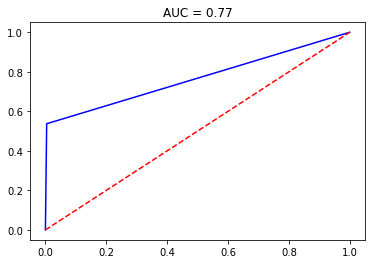

In [74]:
classifier2 = XGBClassifier(n_estimators = 1000).fit(X_train, y_train)
y_pred2    = classifier2.predict(X_test)
saca_metricas(y_test, y_pred2)

**GridSearch con el modelo ganador**

El modelo ganador utiliza el metodo XGB y girdsearch lo vamos a aplicar a Random Forest porque mi ordenador tarda demasiado en ejecutar gridsearch con XGB. He decidido probarlo con RF porque era el segundo modelo que mejores resultados obtenía.

In [75]:
classifier3 =RandomForestClassifier(max_depth = 8).fit(X_train, y_train)

In [76]:
grid_param = {
    'n_estimators': [10, 20, 30, 80, 90],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [5,8,10,12]
}

In [77]:
model_grid = GridSearchCV(estimator=classifier3,
                     param_grid=grid_param,
                     scoring='recall',
                     cv=5,
                     n_jobs=-1)

In [78]:
model_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=8), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 10, 12],
                         'n_estimators': [10, 20, 30, 80, 90]},
             scoring='recall')

In [79]:
print(model_grid.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}


In [80]:
print(model_grid.best_score_)

0.5269192897366622


Aplicamos los resultados obtenidos con GridSearch:

matriz de confusión
[[26402   113]
 [  982  1144]]
accuracy
0.9617680946894313
precision
0.9101034208432777
sensibilidad
0.5380997177798683
especificidad
0.9957382613614935
f1
0.6763227904227017
AUC
0.7669189895706809


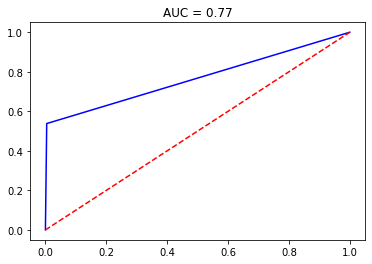

In [81]:
classifier4 = RandomForestClassifier(bootstrap= True, criterion= 'gini', max_depth= 5, n_estimators= 20).fit(X_train, y_train)
y_pred4   = classifier4.predict(X_test)
saca_metricas(y_test, y_pred4)

In [82]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     26515
           1       0.84      0.60      0.70      2126

    accuracy                           0.96     28641
   macro avg       0.91      0.80      0.84     28641
weighted avg       0.96      0.96      0.96     28641



**Balanceo de datos**

Vamos a aplicar a los modelos anteriores el parámetro de class_weight para balancear los datos.

In [83]:
churn.value_counts()

0    88382
1     7085
Name: id, dtype: int64

A continuación, vamos a aplicar los resultados obtenidos con GridSearch incluyendo el parámetro para balancear nuestros datos.

matriz de confusión
[[23151  3364]
 [  162  1964]]
accuracy
0.8768897734017667
precision
0.3686186186186186
sensibilidad
0.9238005644402634
especificidad
0.8731284178766736
f1
0.5269653877112959
AUC
0.8984644911584685


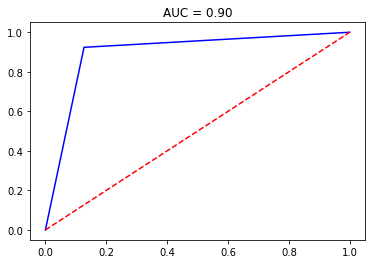

In [84]:
classifier5 =  RandomForestClassifier(bootstrap= True, criterion= 'gini', max_depth= 5, n_estimators= 20, class_weight="balanced").fit(X_train, y_train)
y_pred5    = classifier5.predict(X_test)
saca_metricas(y_test, y_pred5)

In [85]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     26515
           1       0.37      0.92      0.53      2126

    accuracy                           0.88     28641
   macro avg       0.68      0.90      0.73     28641
weighted avg       0.95      0.88      0.90     28641



Comprobamos que no haya sobreajuste en los datos:

In [86]:
results = cross_val_score(estimator=classifier5, X=X_train, y=y_train, cv=5)

In [87]:
results

array([0.80427952, 0.87946128, 0.82065095, 0.87878788, 0.81092406])

In [88]:
print(results.mean())

0.838820736557947


In [89]:
print(results.std())

0.0333181271364617


[10:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nerea\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


matriz de confusión
[[26406   109]
 [  984  1142]]
accuracy
0.9618379246534688
precision
0.9128697042366107
sensibilidad
0.5371589840075258
especificidad
0.9958891193663963
f1
0.6763399466982529
AUC
0.766524051686961


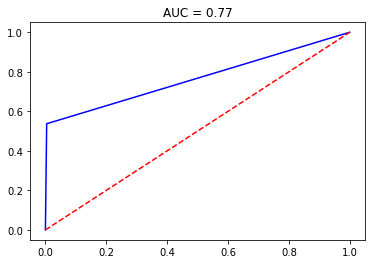

In [90]:
classifier6 = XGBClassifier(n_estimators = 1000,  class_weight="balanced").fit(X_train, y_train)
y_pred6    = classifier6.predict(X_test)
saca_metricas(y_test, y_pred6)

In [91]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26515
           1       0.91      0.54      0.68      2126

    accuracy                           0.96     28641
   macro avg       0.94      0.77      0.83     28641
weighted avg       0.96      0.96      0.96     28641



Después de comparar los resultados obtenidos con los diferentes modelos, voy a elegir como modelo ganador al 'classifier5'. Este modelo utiliza el algoritmo de Random Forest con los hiperparámetros obtenidos con GridSearch además de utilizar el parámetro class_weight para balancear ambas clases. He decidido elegir este modelo porque a pesar de no ser el que mejor accuracy y precision tiene, es el que tiene mejor sensibilidad y especifidad y por esto, mejor curva ROC, lo que quiere decir que clasifica un 0.99 de unos y un 0.78 de ceros bien. 

In [92]:
best_model = classifier5.fit(X_train, y_train)

In [93]:
best_model

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=20)

In [94]:
classifier7 = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, n_estimators=20).fit(X_train, y_train)
y_pred7    = classifier7.predict(X_test)

matriz de confusión
[[20908  5607]
 [    8  2118]]
accuracy
0.8039523759645264
precision
0.2741747572815534
sensibilidad
0.9962370649106302
especificidad
0.7885347916273807
f1
0.4300071058775759
AUC
0.8923859282690055


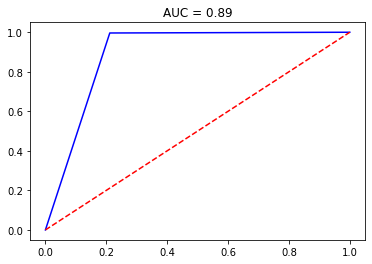

In [95]:
saca_metricas(y_test, y_pred7)

## 6. Predicción

En primer lugar voy a aplicar todos los cambios que he hecho en df_dic a df_ene y a introducir las nuevas variables que he creado.

In [96]:
df_ene.isnull().sum()

edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            90097
incidencia        90720
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
financiacion      86045
imp_financ        86045
descuentos        72673
conexion              2
vel_conexion          3
TV                    0
dtype: int64

In [97]:
for i in df_ene.columns:
    print(i)
    print(df_ene[i].value_counts())

edad
37    1461
60    1431
72    1426
53    1418
20    1414
      ... 
48    1312
33    1312
35    1311
19    1302
84    1289
Name: edad, Length: 68, dtype: int64
facturacion
186.768467    1
248.160805    1
303.178406    1
92.482626     1
206.218005    1
             ..
97.716453     1
296.988387    1
39.591663     1
302.530947    1
357.251060    1
Name: facturacion, Length: 92711, dtype: int64
antiguedad
01/07/2020 10:37 PM    3
01/25/2020 12:51 PM    3
01/14/2020 05:08 PM    3
01/07/2020 03:55 PM    3
01/19/2020 04:57 PM    3
                      ..
03/08/2006 12:19 PM    1
05/31/2013 06:05 PM    1
06/22/2003 10:15 AM    1
10/23/1997 01:13 AM    1
04/24/2012 07:29 AM    1
Name: antiguedad, Length: 92237, dtype: int64
provincia
Valencia                  1941
Asturias                  1934
Murcia                    1931
Navarra                   1930
Zaragoza                  1927
Málaga                    1924
Alicante                  1895
Orense                    1891
Guipúzcoa   

In [98]:
df_ene['num_dt'] = df_ene['num_dt'].fillna(0)

df_ene['incidencia']=df_ene['incidencia'].fillna('NO')
df_ene['incidencia']=df_ene['incidencia'].apply(lambda x: 0 if x=='NO' else 1)

df_ene['financiacion']=df_ene['financiacion'].fillna('NO')
df_ene['financiacion']=df_ene['financiacion'].apply(lambda x: 0 if x=='NO' else 1)

df_ene['imp_financ']=df_ene['imp_financ'].fillna('0')
df_ene['imp_financ']=df_ene['imp_financ'].astype(float)

df_ene['descuentos']=df_ene['descuentos'].fillna('NO')
df_ene['descuentos']=df_ene['descuentos'].apply(lambda x: 0 if x=='NO' else 1)

df_ene['vel_conexion']=df_ene['vel_conexion'].fillna(df_ene['vel_conexion'].mode()[0])
df_ene['vel_conexion']= df_ene['vel_conexion'].str.replace("MB","")
df_ene['vel_conexion'] = pd.to_numeric(df_ene['vel_conexion'],errors='coerce')

df_ene['conexion']=df_ene['conexion'].fillna(df_ene['conexion'].mode()[0])

In [99]:
df_ene.isnull().sum()

edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          0
vel_conexion      0
TV                0
dtype: int64

In [100]:
df_ene.dtypes

edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia          int64
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
financiacion        int64
imp_financ        float64
descuentos          int64
conexion           object
vel_conexion        int64
TV                 object
dtype: object

In [101]:
df_ene.TV.replace(('tv-futbol', 'tv-familiar', 'tv-total'),
                      (1,2,3),inplace=True)

df_ene.conexion.replace(('ADSL', 'FIBRA'), (1,2), inplace=True)

df_ene['antiguedad']=pd.to_datetime(df_ene['antiguedad'])
fecha = "2020-02-01"
ahora = datetime.strptime(fecha, '%Y-%m-%d')
df_ene['antig']=ahora - df_ene['antiguedad']
df_ene['antig']=df_ene['antig'].dt.days

provincias = list(df_ene.provincia.unique())
transform = LabelEncoder()
transform.fit_transform(provincias)
prov = transform.transform(df_ene['provincia'])
df_ene['provincia']= prov

In [102]:
df_ene.dtypes

edad                       int64
facturacion              float64
antiguedad        datetime64[ns]
provincia                  int32
num_lineas                 int64
num_dt                   float64
incidencia                 int64
num_llamad_ent             int64
num_llamad_sal             int64
mb_datos                   int64
seg_llamad_ent             int64
seg_llamad_sal             int64
financiacion               int64
imp_financ               float64
descuentos                 int64
conexion                   int64
vel_conexion               int64
TV                         int64
antig                      int64
dtype: object

In [103]:
df_ene['age_joven'] = df_ene['edad'].apply(lambda x: 1 if x<=32 else 0)
df_ene['age_adulto'] = df_ene['edad'].apply(lambda x: 1 if x>32 & x<60 else 0)
df_ene['age_new'] = df_ene['edad'].apply(lambda x: 1 if x<=32 else 0)

df_ene['vel_conex_new'] = df_ene['vel_conexion'].apply(lambda x: 0 if x<200 else (2 if x>=400 else(1)))

df_ene['num_lin_new'] = df_ene['num_lineas'].apply(lambda x: 0 if x<2 else (1 if x>=2 and x<4 else(2)))

df_ene['lin_impag'] = df_ene['num_dt'].apply(lambda x: 0 if x==0 else (1))

df_dic['tv_futbol'] = df_dic['TV'].apply(lambda x: 1 if x==1 else 0)
df_dic['tv_familiar'] = df_dic['TV'].apply(lambda x: 1 if x==2 else 0)
df_dic['tv_total'] = df_dic['TV'].apply(lambda x: 1 if x==3 else 0)

df_dic['ADSL'] = df_dic['conexion'].apply(lambda x: 1 if x==1 else 0)
df_dic['FIBRA'] = df_dic['conexion'].apply(lambda x: 1 if x==2 else 0)

In [104]:
df_ene2 =df_ene[columnas1]
df_ene2

,edad,incidencia,financiacion,descuentos,TV,lin_impag
id,,,,,,
1,63,0,0,0,1,0
2,84,0,0,1,1,0
3,66,0,0,1,1,0
4,69,0,0,0,2,0
6,51,0,0,0,1,0
...,...,...,...,...,...,...
99996,36,0,0,0,1,0
99997,68,0,1,0,1,0
99998,20,0,0,0,1,0


**Aplicamos modelo ganador**

In [105]:
modelo_proba = classifier7.predict_proba(df_ene2)[:,1]

In [106]:
modelo_proba

array([0.00000000e+00, 4.50556869e-04, 4.50556869e-04, ...,
       7.49462151e-01, 0.00000000e+00, 1.07670624e-01])

In [107]:
modelo_proba = (pd.DataFrame(modelo_proba,columns=['probabilidad'],index=df_ene.index))
modelo_proba.sort_values(by=['probabilidad'],ascending=False,axis=0,inplace=True)

In [108]:
df_ene2.reset_index(inplace=True)

In [109]:
df_ene2.shape

(92711, 7)

In [110]:
df_ene2.head()

,id,edad,incidencia,financiacion,descuentos,TV,lin_impag
0,1,63,0,0,0,1,0
1,2,84,0,0,1,1,0
2,3,66,0,0,1,1,0
3,4,69,0,0,0,2,0
4,6,51,0,0,0,1,0


In [111]:
modelo_proba.reset_index(inplace=True)

In [112]:
modelo_proba.head()

,id,probabilidad
0,57715,0.962749
1,7016,0.962749
2,6952,0.962749
3,46790,0.962453
4,67018,0.962453


In [113]:
results = pd.merge(df_ene2, modelo_proba, on= ['id'])

In [114]:
results2= results.sort_values(by='probabilidad', ascending= False)

In [118]:
results2.head(5)

,id,edad,incidencia,financiacion,descuentos,TV,lin_impag,probabilidad
53493,57715,35,1,0,0,1,1,0.962749
6468,7016,36,1,0,0,1,1,0.962749
6405,6952,35,1,0,0,1,1,0.962749
43372,46790,26,1,0,0,1,1,0.962453
62101,67018,27,1,0,0,1,1,0.962453


In [119]:
results2.tail(5)

,id,edad,incidencia,financiacion,descuentos,TV,lin_impag,probabilidad
46127,49758,57,0,0,1,2,0,0.0
46130,49761,43,0,1,1,2,0,0.0
46134,49765,46,0,0,0,1,0,0.0
46135,49766,77,0,0,1,3,0,0.0
46355,49999,60,0,0,0,1,0,0.0


In [117]:
results.to_csv('resultados.csv')

## 7. Claves de la marcha de clientes

El 96.18% de los clientes que tienen más de un 70% de probabilidad de fuga son los que cumplen las siguientes características:
    - Tienen menos de 40 años.
    - No tienen ninguna incidencia o reclamación.
    - No tienen ningún tipo de financiación o descuento.
    - Tienen contratado el paquete de tv-futbol.
    - No tienen ninguna linea en impago.
    
Además tambien podemos comentar, que los clientes mayores de 40 años, tienen menos de un 19% de probabilidad de fuga, por lo que este segmento de clientes no necesita un incentivo para continuar en la compañía.

Por tanto, la campaña que tendría que lanzar esta compañía es hacia clientes menores de 40 años (40 incluidos), que sean buenos clientes, que no esten financiados o con descuentos por parte de la empresa y que tengan contratado el paquete de fútbol.
